# Classifying Text Features by Class Within Each Axis
This approach attempts to classify the text features by training four separate binary classifiers; one for each axis. This was effective for reducing the noise in the data by allowing SGDClassifier to focus on only two hypothetically polar aspects of the data at a time, and also increased the support for each sample size by decreasing the number of classes it was split into from 16 down to 2 at a time. By checking the distribution of the classification probabilities, we can observe how confident the classifier is in its classifications. Ideally we would want to see a bimodal distribution, showing that the classifier is confident in its classifications. This would suggest that the idea of 4 axis to describe personality is supported by the features of the text being analyzed.
## Import data set and clear out null values

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#read in data
df = pd.read_csv('mbti_cleaned_unsplit2.csv', encoding = "'ISO-8859-1")
df = df.drop('Unnamed: 0', axis=1)

#select only entries with no null values
df = df[pd.notnull(df['clean_posts'])]
df = df[pd.notnull(df['posts'])]


## Prepare corpus/labels and split 30% away for testing

In [2]:
from sklearn.model_selection import train_test_split

#set up and split train and test data
corpus = np.array(df.clean_posts)
labels = np.array(df.type)

train_corpus, test_corpus, train_labels, test_labels  = train_test_split(corpus, labels, test_size=0.3, random_state=42)

## Seperate labels into individual class labels per axis

In [3]:
#split training data labels into new labels for each axis
train_labels_IE = [entry[0] for entry in train_labels]
train_labels_NS = [entry[1] for entry in train_labels]
train_labels_TF = [entry[2] for entry in train_labels]
train_labels_JP = [entry[3] for entry in train_labels]

This step requires to split each four-letter label into each of its letters, creating 4 categories of binary labels. The categories are I/E, N/S, T/F, and J/P. 
## Feature-extract the training corpus

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#vectorize and weight train corpus
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

train_counts = count_vect.fit_transform(train_corpus) #vectorizes text features
train_transform = tfidf_transformer.fit_transform(train_counts) #inverse frequency weighting 

## Initiate a classifier object for each axis
Since not all classes are represented equally, trade precision for recall to balance weights of the classes by passing 'balanced' to `class_weight`

In [5]:
from sklearn.linear_model import SGDClassifier

#train a separate classifier for each axis, enable loss='log' and class_weight='balanced'
sgdc1 = SGDClassifier(loss='log', l1_ratio=0.3, penalty='l1', class_weight='balanced')
sgdc2 = SGDClassifier(loss='log', l1_ratio=0.3, penalty='l1', class_weight='balanced')
sgdc3 = SGDClassifier(loss='log', l1_ratio=0.3, penalty='l1', class_weight='balanced')
sgdc4 = SGDClassifier(loss='log', l1_ratio=0.3, penalty='l1', class_weight='balanced')

## Fit a classifier for each axis with test corpus and corresponding labels 

In [7]:
#fit each classifier with the data and respective train labels
IE = sgdc1.fit(train_transform, train_labels_IE)
NS = sgdc2.fit(train_transform, train_labels_NS)
TF = sgdc3.fit(train_transform, train_labels_TF)
JP = sgdc4.fit(train_transform, train_labels_JP)

## Feature-extract test corpus

In [6]:
#vectorize and weight test data
test_counts = count_vect.transform(test_corpus)
test_transform = tfidf_transformer.transform(test_counts)

## Seperate test labels into individual class labels per axis

In [9]:
#split test labels into new labels for each axis
test_IE = [entry[0] for entry in test_labels]
test_NS = [entry[1] for entry in test_labels]
test_TF = [entry[2] for entry in test_labels]
test_JP = [entry[3] for entry in test_labels]

## Print classifier score on test data

In [10]:
#print the score for each classifier on respective test data
IE_score = sgdc1.score(test_transform, test_IE)
NS_score = sgdc2.score(test_transform, test_NS)
TS_score = sgdc3.score(test_transform, test_TF)
JP_score = sgdc4.score(test_transform, test_JP)

print('IE score: {}'.format(IE_score) + '\n'
     + 'NS score: {}'.format(NS_score) + '\n'
     + 'TF score: {}'.format(TS_score) + '\n'
     + 'JP score: {}'.format(JP_score))



IE score: 0.841336918939685
NS score: 0.870149827122551
TF score: 0.8470995005762582
JP score: 0.8082981175566654


This looks pretty promising; these results are much better than looking at classification of the text from 16 seperate classes.
## Gather the probabilities of each classification per axis
The probability of class A is proportional to the probability of class B in a binary classification problem; 75% probability for class A is proportional to 25% probability for class B). This means that when graphed along one axis, the certainty of the classifiers predictions can be observed. 

In [8]:
#return probabilities for each prediction on test data
probs_IE = IE.predict_proba(test_transform)
probs_NS = NS.predict_proba(test_transform)
probs_TF = TF.predict_proba(test_transform)
probs_JP = JP.predict_proba(test_transform)

This function should give a little more insight into what is happening within each axis being classified.  

In [11]:
from sklearn import metrics

def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    'returns a dataframe of the confusion matrix with true labels compared to predicted labels'
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                labels=level_labels)) 
    return (cm_frame) 

## Plot the distributions of probabilities per axis
### I - E Axis

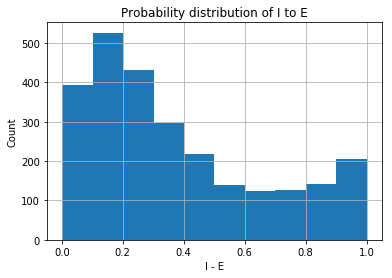

             precision    recall  f1-score   support

          E       0.61      0.78      0.69       581
          I       0.93      0.86      0.89      2022

avg / total       0.86      0.84      0.85      2603

          Predicted:      
                   E     I
Actual: E        454   127
        I        286  1736


In [12]:
#plot the distribution of the first probability element
pd.DataFrame(probs_IE[:,0]).hist()
plt.xlabel('I - E')
plt.ylabel('Count')
plt.title('Probability distribution of I to E')
plt.show()

#show metrics of the classification
IE_pred = sgdc1.predict(test_transform)

print(metrics.classification_report(test_IE, IE_pred, sgdc1.classes_))
print(display_confusion_matrix(test_IE, IE_pred, sgdc1.classes_))

### S - N Axis

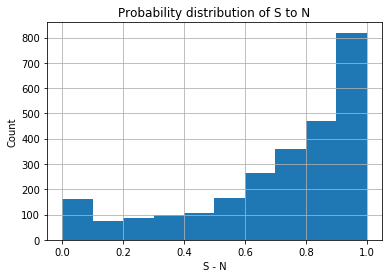

             precision    recall  f1-score   support

          N       0.96      0.88      0.92      2259
          S       0.51      0.78      0.61       344

avg / total       0.90      0.87      0.88      2603

          Predicted:     
                   N    S
Actual: N       1998  261
        S         77  267


In [13]:
pd.DataFrame((probs_NS[:,0])).hist()
plt.xlabel('S - N')
plt.ylabel('Count')
plt.title('Probability distribution of S to N')
plt.show()

NS_pred = sgdc2.predict(test_transform)

print(metrics.classification_report(test_NS, NS_pred, sgdc2.classes_))
print(display_confusion_matrix(test_NS, NS_pred, sgdc2.classes_))

### T - F Axis

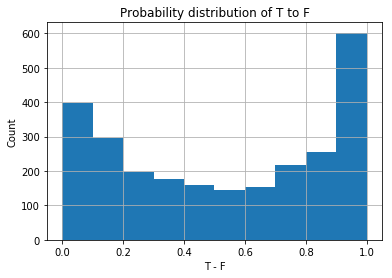

             precision    recall  f1-score   support

          F       0.87      0.84      0.86      1418
          T       0.82      0.85      0.84      1185

avg / total       0.85      0.85      0.85      2603

          Predicted:      
                   F     T
Actual: F       1197   221
        T        177  1008


In [14]:
pd.DataFrame((probs_TF[:,0])).hist()
plt.xlabel('T - F')
plt.ylabel('Count')
plt.title('Probability distribution of T to F')
plt.show()

TF_pred = sgdc3.predict(test_transform)

print(metrics.classification_report(test_TF, TF_pred, sgdc3.classes_))
print(display_confusion_matrix(test_TF, TF_pred, sgdc3.classes_))

### P - J Axis

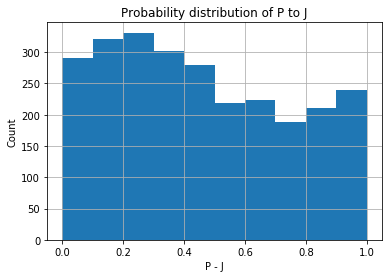

             precision    recall  f1-score   support

          J       0.74      0.79      0.76      1015
          P       0.86      0.82      0.84      1588

avg / total       0.81      0.81      0.81      2603

          Predicted:      
                   J     P
Actual: J        798   217
        P        282  1306


In [15]:
pd.DataFrame((probs_JP[:,0])).hist()
plt.xlabel('P - J')
plt.ylabel('Count')
plt.title('Probability distribution of P to J')
plt.show()

JP_pred = sgdc4.predict(test_transform)

print(metrics.classification_report(test_JP, JP_pred, sgdc4.classes_))
print(display_confusion_matrix(test_JP, JP_pred, sgdc4.classes_))

The lack of support in certain classes was affecting its ability to predict them, but with the balanced weighting there was a reasonable bimodal distribution along each axis. Pertaining to the cleaned posts, the results seemed to suggest support for MBTI as a construct of personality from a text based perspective. Looking at each graph, the classifiers were very certain in their classifications and had less probabilities distributed around the center, which was the original problem with the actual MBTI personality test. However, this success needs to be viewed in context to Sample 3 (recall that Sample 3 had all mentions of any of the 16 classes removed). Lets test the classifier on Sample 3 (the clean posts with all references to personality types, like "ENFJ" for example, removed).
## Prepare second set of test data with `no_ref` as corpus

In [18]:
#declare corpus and labels 
corpus_no_ref = np.array(df.no_ref)
labels_no_ref = np.array(df.type)

#split data labels into new labels for each axis
labels_IE = [entry[0] for entry in labels_no_ref]
labels_NS = [entry[1] for entry in labels_no_ref]
labels_TF = [entry[2] for entry in labels_no_ref]
labels_JP = [entry[3] for entry in labels_no_ref]

## Feature-extract and weight 

In [22]:
X_nr_counts = count_vect.transform(corpus_no_ref)
X_nr = tfidf_transformer.transform(X_nr_counts)

## Print scores of each classifier

In [24]:
IE_score_nr = sgdc1.score(X_nr_counts, labels_IE)
NS_score_nr = sgdc2.score(X_nr_counts, labels_NS)
TS_score_nr = sgdc3.score(X_nr_counts, labels_TF)
JP_score_nr = sgdc4.score(X_nr_counts, labels_JP)

print('IE score: {}'.format(IE_score_nr) + '\n'
     + 'NS score: {}'.format(NS_score_nr) + '\n'
     + 'TF score: {}'.format(TS_score_nr) + '\n'
     + 'JP score: {}'.format(JP_score_nr))

IE score: 0.7514410883098916
NS score: 0.7859119206824994
TF score: 0.6963338713396356
JP score: 0.670970717085543


As we can see the accuracy too a big hit with the remove of the class names as a text feature. 

# Predict probabilities of classifications

In [23]:
probs_IE_nr = IE.predict_proba(X_nr)
probs_NS_nr = NS.predict_proba(X_nr)
probs_TF_nr = TF.predict_proba(X_nr)
probs_JP_nr = JP.predict_proba(X_nr)

## Plot distribution of classification probabilities

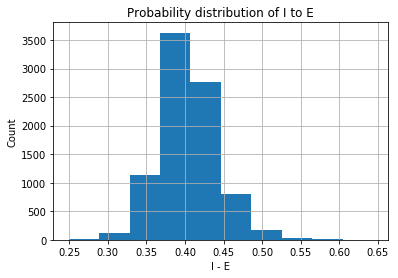

In [25]:
#plot the distribution of the first probability element
pd.DataFrame(probs_IE_nr[:,0]).hist()
plt.xlabel('I - E')
plt.ylabel('Count')
plt.title('Probability distribution of I to E')
plt.show()


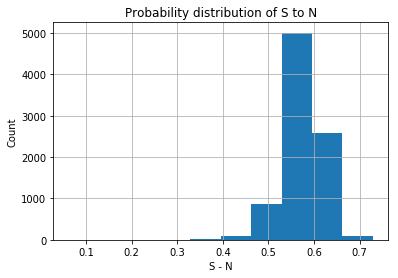

In [28]:
#plot the distribution of the first probability element
pd.DataFrame(probs_NS_nr[:,0]).hist()
plt.xlabel('S - N')
plt.ylabel('Count')
plt.title('Probability distribution of S to N')
plt.show()


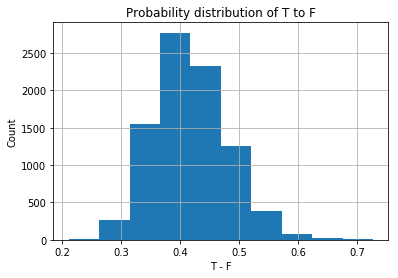

In [30]:
#plot the distribution of the first probability element
pd.DataFrame(probs_TF_nr[:,0]).hist()
plt.xlabel('T - F')
plt.ylabel('Count')
plt.title('Probability distribution of T to F')
plt.show()


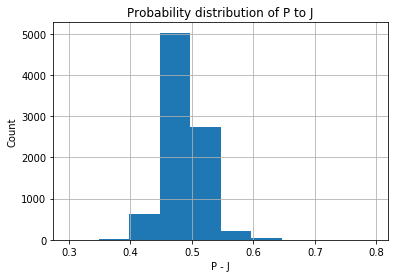

In [29]:
pd.DataFrame((probs_JP_nr[:,0])).hist()
plt.xlabel('P - J')
plt.ylabel('Count')
plt.title('Probability distribution of P to J')
plt.show()

From this it is apparent that the classifier trained on `clean_posts` did not generalize over in terms of predicting power on `no_ref`, confirming my suspicion that the each of the 16 class references when present in the data are the most discriminative features of the personality classes.